In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor,outlier_test
from scipy.spatial.distance import pdist, squareform,cdist
from scipy import exp
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from time import time
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,auc,make_scorer,roc_auc_score,f1_score,roc_curve,classification_report,precision_recall_curve,confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE,RandomOverSampler
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from hyperopt import Trials
from hyperopt import tpe
from hyperopt import fmin
from sklearn.model_selection import StratifiedKFold
from functools import partial
import lightgbm as gbm

In [ ]:
import warnings
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200
warnings.filterwarnings('ignore', category = RuntimeWarning)

#### helper functions

In [3]:
#helper functions
def plot_distribution_cat(data,column_list):
    plt.figure(figsize = (20, 16))
    colors = OrderedDict({1: 'red', 0: 'green'})
    churn_mapping = OrderedDict({0: 'no churn', 1: 'churn'})
    for i,col in enumerate(column_list,start=1):
        ax = plt.subplot(7,3,i)
        for level,color in colors.items():
            sns.kdeplot(churn_data.loc[churn_data['Churn'] == level, col],ax=ax,color=color,label=churn_mapping[level])
        plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')
    plt.subplots_adjust(top = 2)
    
def boxplot_distribution(column_list):
    plt.figure(figsize = (20, 16))
    colors = OrderedDict({1: 'red', 0: 'green'})
    poverty_mapping = ['churn','no_churn']
    for i,col in enumerate(column_list):
        ax = plt.subplot(4,2,i+1)
        sns.boxplot(x='Churn',y=col,data=churn_data,ax=ax,palette=colors)
        plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')
        locs,labels = plt.xticks()
        plt.xticks(locs,poverty_mapping)
    plt.subplots_adjust(top = 2)

def corr_heatmap(column_list,method='pearson'):
    plt.figure(figsize = (8, 10))
    corr = churn_data[column_list].corr(method)
    sns.heatmap(corr,cmap='binary_r')
    plt.show()    

def dict_to_pd(model_name,results):
    if model_name == 'LR':
        dt = sorted([{'loss':trial['loss'],'C':trial['params']['C'],'penalty':trial['params']['penalty']['penalty'],'solver':trial['params']['penalty']['solver'],'score':trial['score'],'score_std':trial['score_std'],'iteration':trial['iteration']} for trial in results],key=lambda x:x['loss'])
        results_pd = pd.DataFrame(dt)
    elif model_name == 'SVC':
        dt = sorted([{'loss':trial['loss'],'C':trial['params']['C'],'kernel':trial['params']['kernel'],'score':trial['score'],'score_std':trial['score_std'],'iteration':trial['iteration']} for trial in results],key=lambda x:x['loss'])
        results_pd = pd.DataFrame(dt)
    elif model_name == 'GBM':
        dt = sorted([{'loss':trial['loss'],'score':trial['score'],'score_std':trial['score_std'],'n_estimators':trial['params']['n_estimators'],'bagging_fraction':trial['params']['bagging_fraction'],'boosting_type':trial['params']['boosting_type'],'colsample_bytree':trial['params']['colsample_bytree'],\
             'min_child_samples':trial['params']['min_child_samples'],'min_child_weight':trial['params']['min_child_weight'],'min_split_gain':trial['params']['min_split_gain'],'num_leaves':trial['params']['num_leaves'],'reg_alpha':trial['params']['reg_alpha'],'reg_lambda':trial['params']['reg_lambda'],\
             'subsample_for_bin':trial['params']['subsample_for_bin'],'subsample':trial['params']['subsample'],'train_std':trial['time_std'],'max_depth':trial['params']['max_depth']} for trial in results],key=lambda x:x['loss'])
        results_pd = pd.DataFrame(dt)
    elif model_name == 'RF':
        dt = sorted([{'loss':trial['loss'],'max_depth':trial['params']['max_depth'],'min_samples_split':trial['params']['min_samples_split'],'min_samples_leaf':trial['params']['min_samples_leaf'],'max_features':trial['params']['max_features'],'score':trial['score'],'score_std':trial['score_std'],'iteration':trial['iteration']} for trial in results],key=lambda x:x['loss'])
        results_pd = pd.DataFrame(dt)
    return results_pd

def build_gauss_kernel(X1,X2,gamma):
    pairwise_dists = cdist(X1, X2, 'sqeuclidean')
    K = exp(-pairwise_dists ** 2 / gamma ** 2)
    return K

def plot_precision_recall_curve(y_true,y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba) 
       #retrieve probability of being 1(in second column of probs_y)
    pr_auc = auc(recall, precision)
    #print('auc--',pr_auc)
    plt.title("Precision-Recall vs Threshold Chart")
    plt.plot(thresholds, precision[: -1], "b--", label="Precision")
    plt.plot(thresholds, recall[: -1], "r--", label="Recall")
    plt.ylabel("Precision, Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0,1])
    plt.show()

def plot_roc_curve(y_true,y_pred_proba):
    fpr,tpr,thresholds = roc_curve(y_true,y_pred_proba,pos_label=1)
    auc_ = auc(fpr,tpr)
    plt.plot(fpr, tpr, color='g', lw=1.0,label='AUC {}'.format(np.round(auc_,2)))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="best")
    plt.show()
    
def plot_feature_importances(df, n = 20, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

#### Reading Tain and Test Data

In [4]:
churn_data = pd.read_csv('Train_data.csv')
churn_data_test = pd.read_csv('Test_data.csv')

In [5]:
churn_data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,number customer service calls,Churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [6]:
#we can drop the phone number column as it would not be helpful for our model
churn_data.drop('phone number',axis=1,inplace=True)
churn_data_test.drop('phone number',axis=1,inplace=True)

#### Renaming the columns

In [7]:
rename_cols = {'total day calls':'total_day_calls','total day charge':'total_day_charge','total day minutes':'total_day_minutes','total eve calls':'total_eve_calls','total eve charge':'total_eve_charge','total eve minutes':'total_eve_minutes','total intl calls':'total_intl_calls','total intl charge':'total_intl_charge','total intl minutes':'total_intl_minutes','total night calls':'total_night_calls','total night charge':'total_night_charge','total night minutes':'total_night_minutes',\
              'account length':'account_length','area code':'area_code','international plan':'international_plan','voice mail plan':'voice_mail_plan','number vmail messages':'number_vmail_messages','number customer service calls':'cust_service_calls'}
churn_data.rename(rename_cols,axis=1,inplace=True)
churn_data_test.rename(rename_cols,axis=1,inplace=True)

#### encoding target variable

In [8]:
#encoding target variable
churn_data['Churn'][churn_data['Churn'] == ' True.'] = 1
churn_data['Churn'][churn_data['Churn'] == ' False.'] = 0
churn_data['Churn'] = churn_data['Churn'].astype('int8')
#encoding target variable on test data
churn_data_test['Churn'][churn_data_test['Churn'] == ' True.'] = 1
churn_data_test['Churn'][churn_data_test['Churn'] == ' False.'] = 0
churn_data_test['Churn'] = churn_data_test['Churn'].astype('int8')

C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.

#### encoding categorical variables

In [9]:
#encoding categorical variables
churn_data['international_plan'][churn_data['international_plan'] == ' yes'] = 1
churn_data['international_plan'][churn_data['international_plan'] == ' no'] = 0
churn_data['voice_mail_plan'][churn_data['voice_mail_plan'] == ' yes'] = 1
churn_data['voice_mail_plan'][churn_data['voice_mail_plan'] == ' no'] = 0
churn_data['international_plan'] = churn_data['international_plan'].astype('int8')
churn_data['voice_mail_plan'] = churn_data['voice_mail_plan'].astype('int8')
#encoding categorical variables on test data
churn_data_test['international_plan'][churn_data_test['international_plan'] == ' yes'] = 1
churn_data_test['international_plan'][churn_data_test['international_plan'] == ' no'] = 0
churn_data_test['voice_mail_plan'][churn_data_test['voice_mail_plan'] == ' yes'] = 1
churn_data_test['voice_mail_plan'][churn_data_test['voice_mail_plan'] == ' no'] = 0
churn_data_test['international_plan'] = churn_data_test['international_plan'].astype('int8')
churn_data_test['voice_mail_plan'] = churn_data_test['voice_mail_plan'].astype('int8')

C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\farazz\Anaconda3\

In [335]:
churn_data.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,cust_service_calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


#### Checking for null values if any in the dataset

In [441]:
#no null values found
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
state                    3333 non-null object
account_length           3333 non-null int64
area_code                3333 non-null int64
international_plan       3333 non-null int8
voice_mail_plan          3333 non-null int8
number_vmail_messages    3333 non-null int64
total_day_minutes        3333 non-null float64
total_day_calls          3333 non-null int64
total_day_charge         3333 non-null float64
total_eve_minutes        3333 non-null float64
total_eve_calls          3333 non-null int64
total_eve_charge         3333 non-null float64
total_night_minutes      3333 non-null float64
total_night_calls        3333 non-null int64
total_night_charge       3333 non-null float64
total_intl_minutes       3333 non-null float64
total_intl_calls         3333 non-null int64
total_intl_charge        3333 non-null float64
cust_service_calls       3333 non-null int64
Churn                  

In [495]:
churn_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 38 columns):
account_length                   1667 non-null int64
account_length_diff_state_agg    1667 non-null float64
area_code                        1667 non-null float64
average_calls_per_day            1667 non-null float64
cust_ser_calls_diff_state_agg    1667 non-null float64
cust_service_calls               1667 non-null int64
day_calls_diff_state_agg         1667 non-null float64
day_min_per_call                 1667 non-null float64
eve_calls_diff_state_agg         1667 non-null float64
eve_min_per_call                 1667 non-null float64
international_plan               1667 non-null int8
intl_min_per_call                1667 non-null float64
night_calls_diff_state_agg       1667 non-null float64
night_min_per_call               1666 non-null float64
number_vmail_messages            1667 non-null int64
revenue                          1667 non-null float64
revenue_diff_state_agg

In [337]:
#observing the description of the dataset
churn_data.describe()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,cust_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


## Exploratory Data Analysis

In [338]:
##visualizaing the distribution of continuous features
continuous_features = churn_data.select_dtypes(include=['float64'])

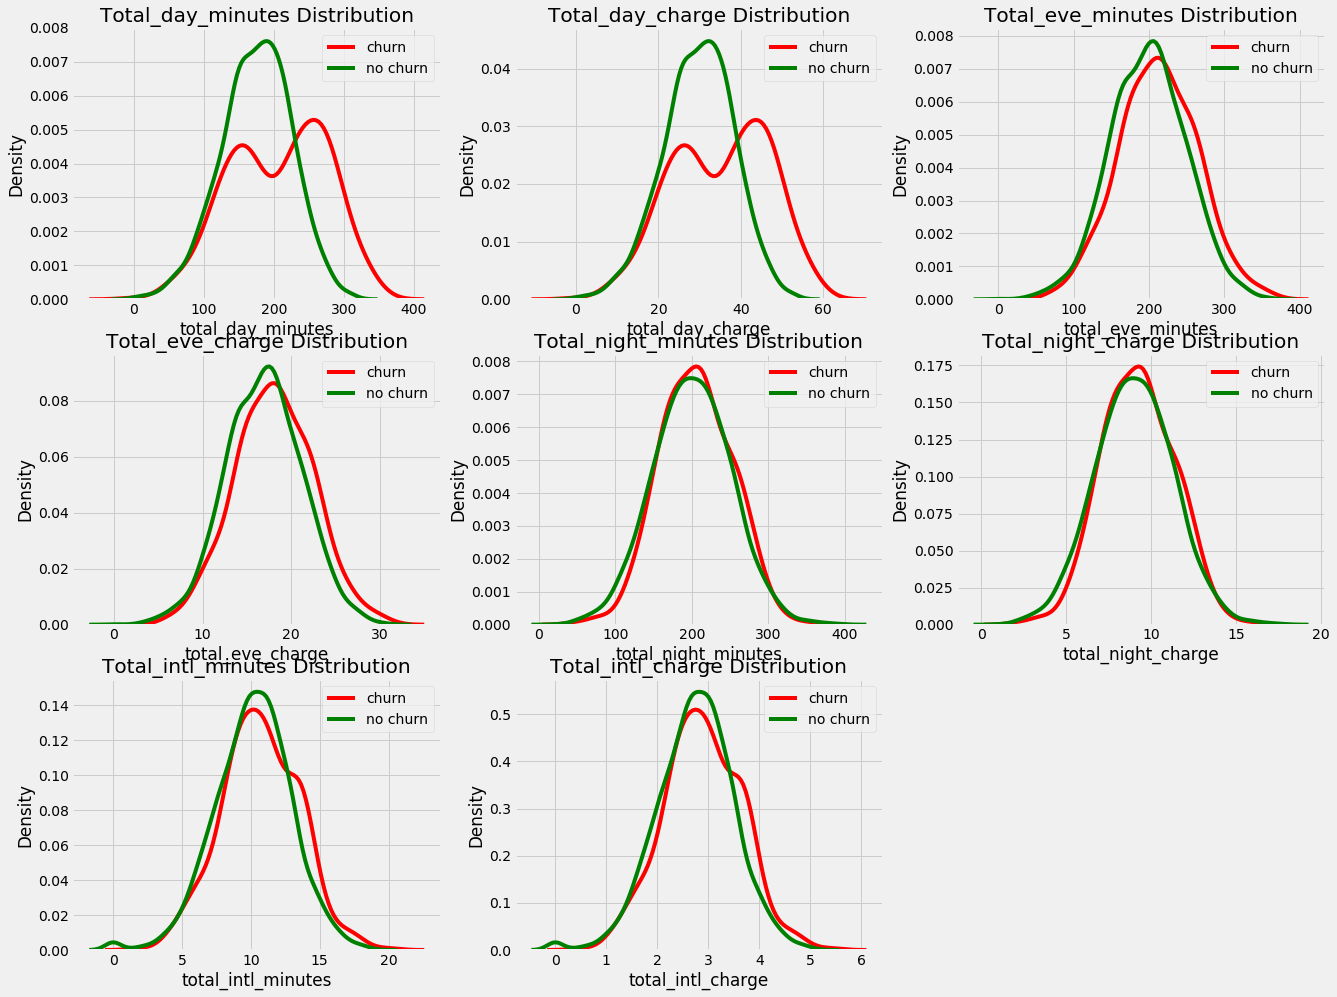

In [339]:
plot_distribution_cat(churn_data,continuous_features)

In [340]:
discrete_features = churn_data.select_dtypes(include=['int64'])
discrete_features.drop('area_code',axis=1,inplace=True)

C:\Users\farazz\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


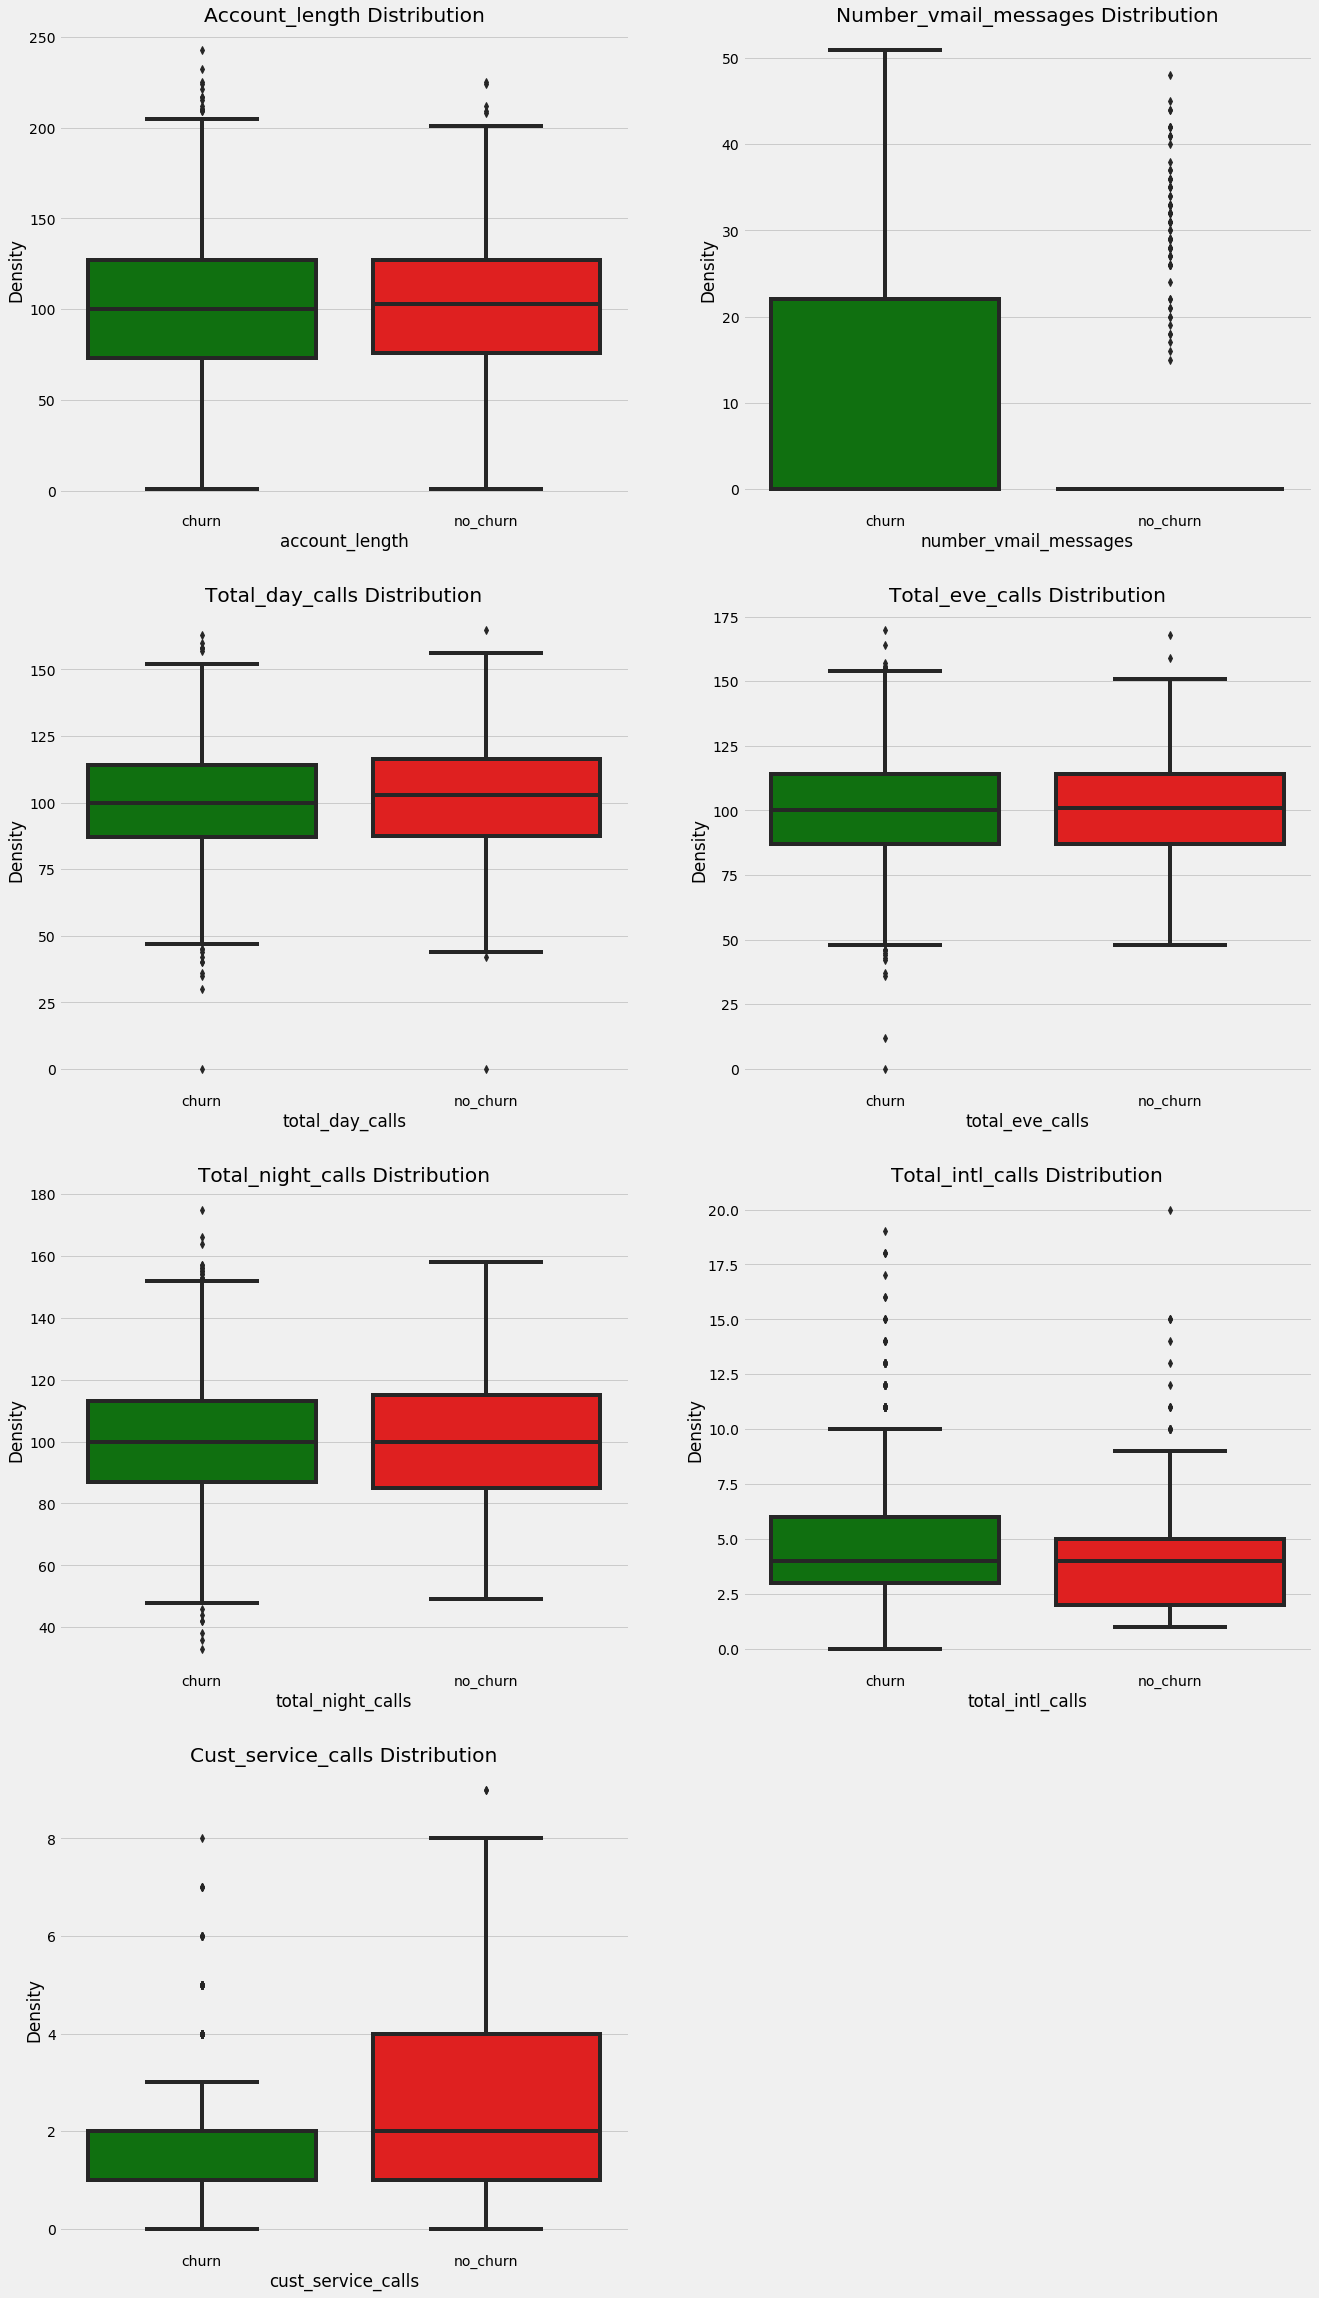

In [341]:
boxplot_distribution(discrete_features.columns)

#### Churn by State

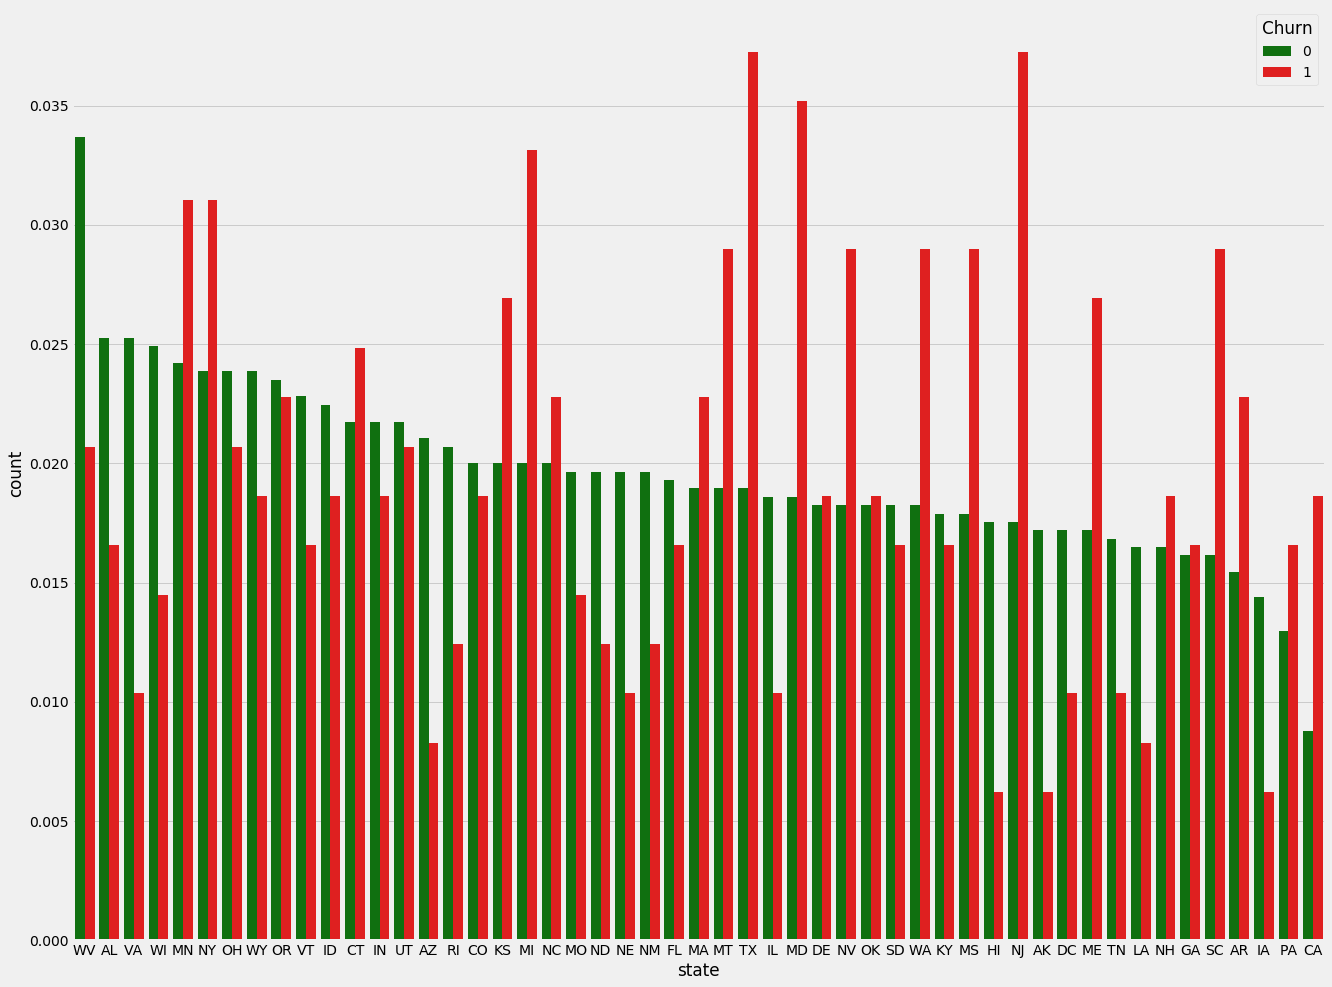

In [342]:
Churn_by_state = churn_data.groupby(['Churn'])['state'].value_counts(normalize=True)
Churn_by_state = Churn_by_state.rename('count')
Churn_by_state = Churn_by_state.reset_index(['Churn','state'])
plt.figure(figsize = (20, 16))
sns.barplot(x='state', y="count", hue="Churn", data=Churn_by_state,palette=OrderedDict({1: 'red', 0: 'green'}))
plt.show()

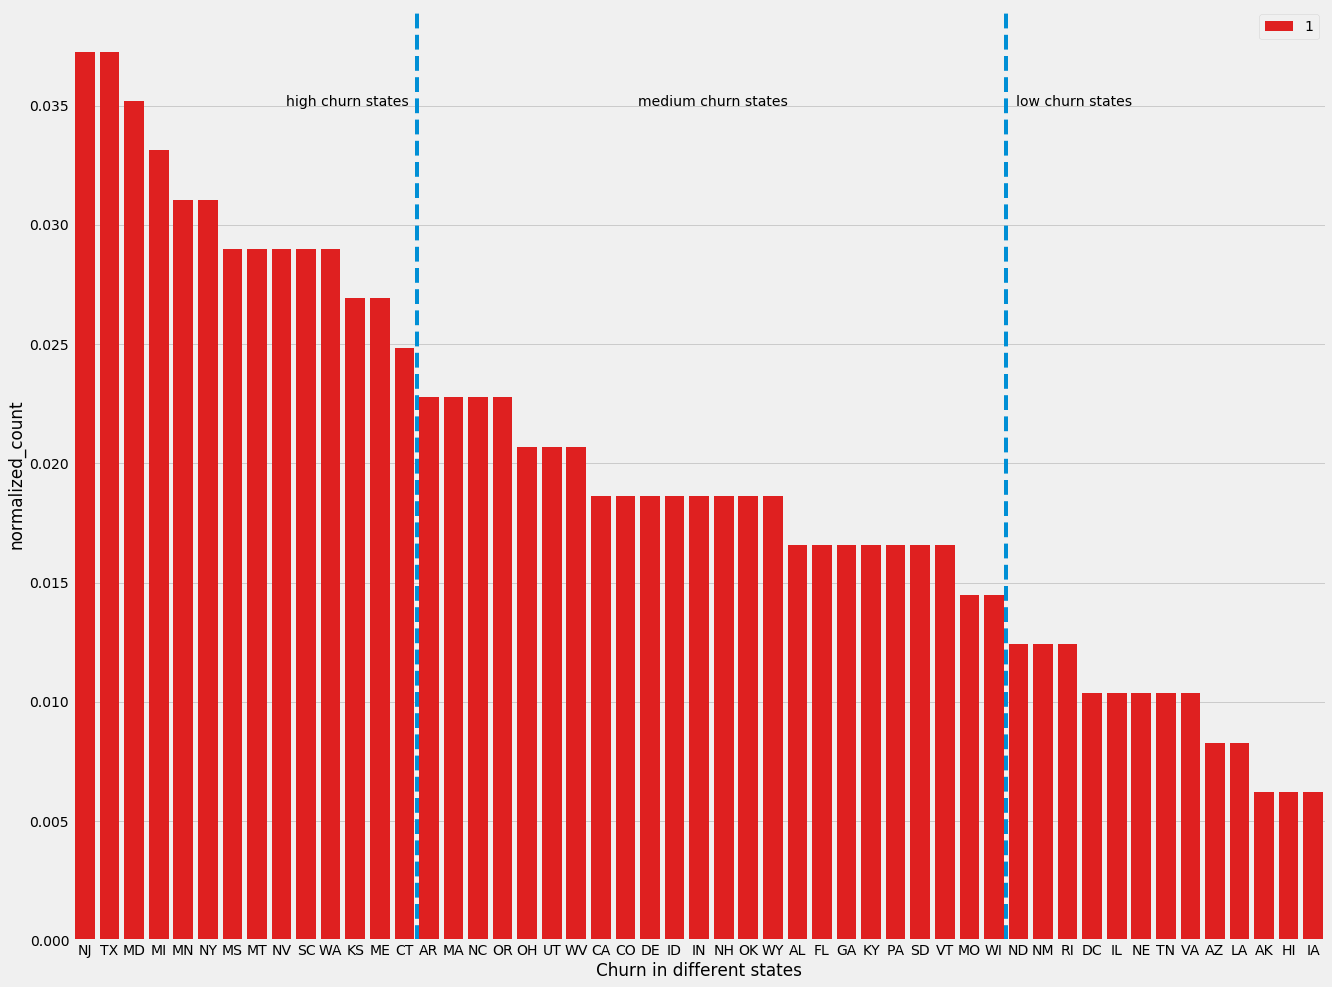

In [343]:
churn_grouped = Churn_by_state[Churn_by_state['Churn'] == 1]
plt.figure(figsize = (20, 16))
sns.barplot(x='state', y="count", hue="Churn", data=churn_grouped,palette=OrderedDict({1: 'red', 0: 'green'}))
plt.axvline(x=13.5,linestyle='--')
plt.text(x=8.2, y=0.035, s='high churn states', alpha=1.0, color='black')
plt.axvline(x=37.5,linestyle='--')
plt.text(x=37.9, y=0.035, s='low churn states', alpha=1.0, color='black')
plt.text(x=22.5, y=0.035, s='medium churn states', alpha=1.0, color='black')
plt.xlabel('Churn in different states')
plt.ylabel('normalized_count')
#locs,labels = plt.xticks()
#plt.xticks(locs,label,rotation=rotation)
plt.legend(loc='best')
plt.show()

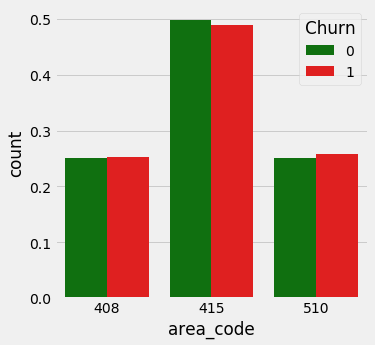

In [344]:
Churn_by_area_code = churn_data.groupby(['Churn'])['area_code'].value_counts(normalize=True)
Churn_by_area_code = Churn_by_area_code.rename('count')
Churn_by_area_code = Churn_by_area_code.reset_index(['Churn','area_code'])
plt.figure(figsize = (5, 5))
sns.barplot(x='area_code', y="count", hue="Churn", data=Churn_by_area_code,palette=OrderedDict({1: 'red', 0: 'green'}))
plt.show()

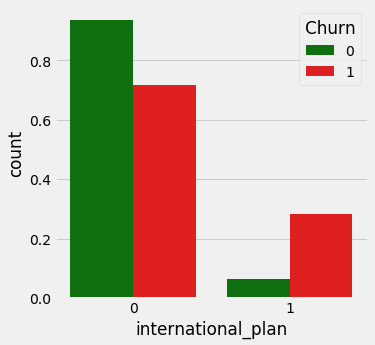

In [345]:
Churn_by_intl_plan = churn_data.groupby(['Churn'])['international_plan'].value_counts(normalize=True)
Churn_by_intl_plan = Churn_by_intl_plan.rename('count')
Churn_by_intl_plan = Churn_by_intl_plan.reset_index(['Churn','international_plan'])
plt.figure(figsize = (5, 5))
sns.barplot(x='international_plan', y="count", hue="Churn", data=Churn_by_intl_plan,palette=OrderedDict({1: 'red', 0: 'green'}))
plt.show()

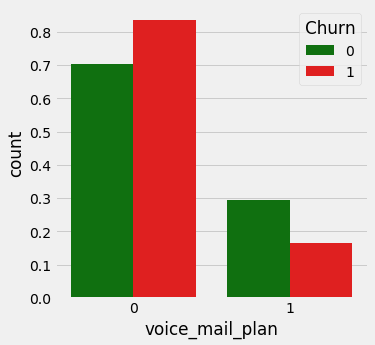

In [346]:
Churn_by_voice_mail = churn_data.groupby(['Churn'])['voice_mail_plan'].value_counts(normalize=True)
Churn_by_voice_mail = Churn_by_voice_mail.rename('count')
Churn_by_voice_mail = Churn_by_voice_mail.reset_index(['Churn','voice_mail_plan'])
plt.figure(figsize = (5, 5))
sns.barplot(x='voice_mail_plan', y="count", hue="Churn", data=Churn_by_voice_mail,palette=OrderedDict({1: 'red', 0: 'green'}))
plt.show()

## Feature Engineering

In [10]:
#average calls per day
churn_data['average_calls_per_day'] = (churn_data['total_day_calls'] + churn_data['total_eve_calls'] + churn_data['total_night_calls'])/churn_data['account_length']
#average calls per day test data
churn_data_test['average_calls_per_day'] = (churn_data_test['total_day_calls'] + churn_data_test['total_eve_calls'] + churn_data_test['total_night_calls'])/churn_data_test['account_length']
#average calls per day test data

In [11]:
#voice and international plan
churn_data['voice_and_international_plan'] = 0
churn_data['voice_and_international_plan'][(churn_data['voice_mail_plan'] == 1) & (churn_data['international_plan'] == 1)] = 1
churn_data['voice_and_international_plan'] = churn_data['voice_and_international_plan'].astype('int8')
#voice and international plan test data
#voice and international plan
churn_data_test['voice_and_international_plan'] = 0
churn_data_test['voice_and_international_plan'][(churn_data_test['voice_mail_plan'] == 1) & (churn_data_test['international_plan'] == 1)] = 1

C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
#minutes / call
churn_data['day_min_per_call'] = churn_data['total_day_minutes'] / churn_data['total_day_calls']
churn_data['eve_min_per_call'] = churn_data['total_eve_minutes'] / churn_data['total_eve_calls']
churn_data['night_min_per_call'] = churn_data['total_night_minutes'] / churn_data['total_night_calls']
churn_data['total_min_per_call'] = churn_data['day_min_per_call'] + churn_data['eve_min_per_call'] + churn_data['night_min_per_call']
#minutes / call test data
churn_data_test['day_min_per_call'] = churn_data_test['total_day_minutes'] / churn_data_test['total_day_calls']
churn_data_test['eve_min_per_call'] = churn_data_test['total_eve_minutes'] / churn_data_test['total_eve_calls']
churn_data_test['night_min_per_call'] = churn_data_test['total_night_minutes'] / churn_data_test['total_night_calls']
churn_data_test['total_min_per_call'] = churn_data_test['day_min_per_call'] + churn_data_test['eve_min_per_call'] + churn_data_test['night_min_per_call']

In [19]:
#intl min/call
churn_data['intl_min_per_call'] = churn_data['total_intl_minutes'] / churn_data['total_intl_calls']
#intl min/call test data
churn_data_test['intl_min_per_call'] = churn_data_test['total_intl_minutes'] / churn_data['total_intl_calls']

In [13]:
#revenue from customer
churn_data['revenue'] = churn_data['total_day_charge'] + churn_data['total_eve_charge'] + churn_data['total_night_charge'] + churn_data['total_intl_charge']
churn_data_test['revenue'] = churn_data_test['total_day_charge'] + churn_data_test['total_eve_charge'] + churn_data_test['total_night_charge'] + churn_data_test['total_intl_charge']
#total calls made by customer
churn_data['total_calls'] = churn_data['total_day_calls'] + churn_data['total_eve_calls'] + churn_data['total_night_calls'] + churn_data['total_intl_calls']
churn_data_test['total_calls'] = churn_data_test['total_day_calls'] + churn_data_test['total_eve_calls'] + churn_data_test['total_night_calls'] + churn_data_test['total_intl_calls']
#total call minutes
churn_data['total_minutes'] = churn_data['total_day_minutes'] + churn_data['total_eve_minutes'] + churn_data['total_night_minutes'] + churn_data['total_intl_minutes']
churn_data_test['total_minutes'] = churn_data_test['total_day_minutes'] + churn_data_test['total_eve_minutes'] + churn_data_test['total_night_minutes'] + churn_data_test['total_intl_minutes']
#revenue per day
churn_data['revenue_per_day'] = churn_data['revenue'] / churn_data['account_length']
churn_data_test['revenue_per_day'] = churn_data_test['revenue'] / churn_data_test['account_length']
#

In [21]:
#difference from state aggregate
churn_data['cust_ser_calls_diff_state_agg'] = churn_data.groupby(['state'])['cust_service_calls'].transform('median') - churn_data['cust_service_calls']
churn_data['day_calls_diff_state_agg'] = churn_data.groupby(['state'])['total_day_calls'].transform('median') - churn_data['total_day_calls']
churn_data['eve_calls_diff_state_agg'] = churn_data.groupby(['state'])['total_eve_calls'].transform('median') - churn_data['total_eve_calls']
churn_data['night_calls_diff_state_agg'] = churn_data.groupby(['state'])['total_night_calls'].transform('median') - churn_data['total_night_calls']
churn_data['account_length_diff_state_agg'] = churn_data.groupby(['state'])['account_length'].transform('median') - churn_data['account_length']
churn_data['revenue_diff_state_agg'] = churn_data.groupby(['state'])['revenue'].transform('median') - churn_data['revenue']
#difference from state aggregate test data
churn_data_test['cust_ser_calls_diff_state_agg'] = churn_data_test.groupby(['state'])['cust_service_calls'].transform('median') - churn_data_test['cust_service_calls']
churn_data_test['day_calls_diff_state_agg'] = churn_data_test.groupby(['state'])['total_day_calls'].transform('median') - churn_data_test['total_day_calls']
churn_data_test['eve_calls_diff_state_agg'] = churn_data_test.groupby(['state'])['total_eve_calls'].transform('median') - churn_data_test['total_eve_calls']
churn_data_test['night_calls_diff_state_agg'] = churn_data_test.groupby(['state'])['total_night_calls'].transform('median') - churn_data_test['total_night_calls']
churn_data_test['account_length_diff_state_agg'] = churn_data_test.groupby(['state'])['account_length'].transform('median') - churn_data_test['account_length']
churn_data_test['revenue_diff_state_agg'] = churn_data_test.groupby(['state'])['revenue'].transform('median') - churn_data_test['revenue']

In [14]:
#user belonging to which statewise churn segment 
churn_states = churn_data.groupby(['Churn'])['state'].value_counts(normalize=True)
churn_states = churn_states.rename('count')
churn_states = churn_states.reset_index(['Churn','state'])
churn_states = churn_states[churn_states['Churn'] == 1]
high_churn_states = churn_states['state'][churn_states['count'] >= 0.024]
med_churn_states = churn_states['state'][(churn_states['count'] < 0.024) & (churn_states['count'] >= 0.014)]
churn_data['state_churn_segment'] = 0
churn_data['state_churn_segment'][churn_data['state'].isin(high_churn_states)] = 2
churn_data['state_churn_segment'][churn_data['state'].isin(med_churn_states)] = 1
#user belonging to which statewise churn segment test data
churn_data_test['state_churn_segment'] = 0
churn_data_test['state_churn_segment'][churn_data_test['state'].isin(high_churn_states)] = 2
churn_data_test['state_churn_segment'][churn_data_test['state'].isin(med_churn_states)] = 1

C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\farazz\Anaconda3\lib\site-packages\ipyk

In [15]:
#target encoding categorical variables training data
churn_data_X = churn_data[churn_data.columns.difference(['Churn'])]
churn_data_y = churn_data['Churn']
encoder = TargetEncoder(cols=['state','area_code']).fit(churn_data_X,churn_data_y)
churn_data = encoder.transform(churn_data_X,churn_data_y)
churn_data['Churn'] = churn_data_y

In [16]:
churn_data_test_X = churn_data_test[churn_data_test.columns.difference(['Churn'])]
churn_data_test_y = churn_data_test['Churn']
churn_data_test = encoder.transform(churn_data_test_X)
churn_data_test['Churn'] = churn_data_test_y

In [17]:
engineered_cont_features = ['average_calls_per_day', 'day_min_per_call', 'eve_min_per_call',
       'night_min_per_call', 'total_min_per_call', 'revenue', 'total_calls',
       'total_minutes', 'revenue_per_day', 'intl_min_per_call',
       'cust_ser_calls_diff_state_agg', 'day_calls_diff_state_agg',
       'eve_calls_diff_state_agg', 'night_calls_diff_state_agg', 'account_length_diff_state_agg','revenue_diff_state_agg']

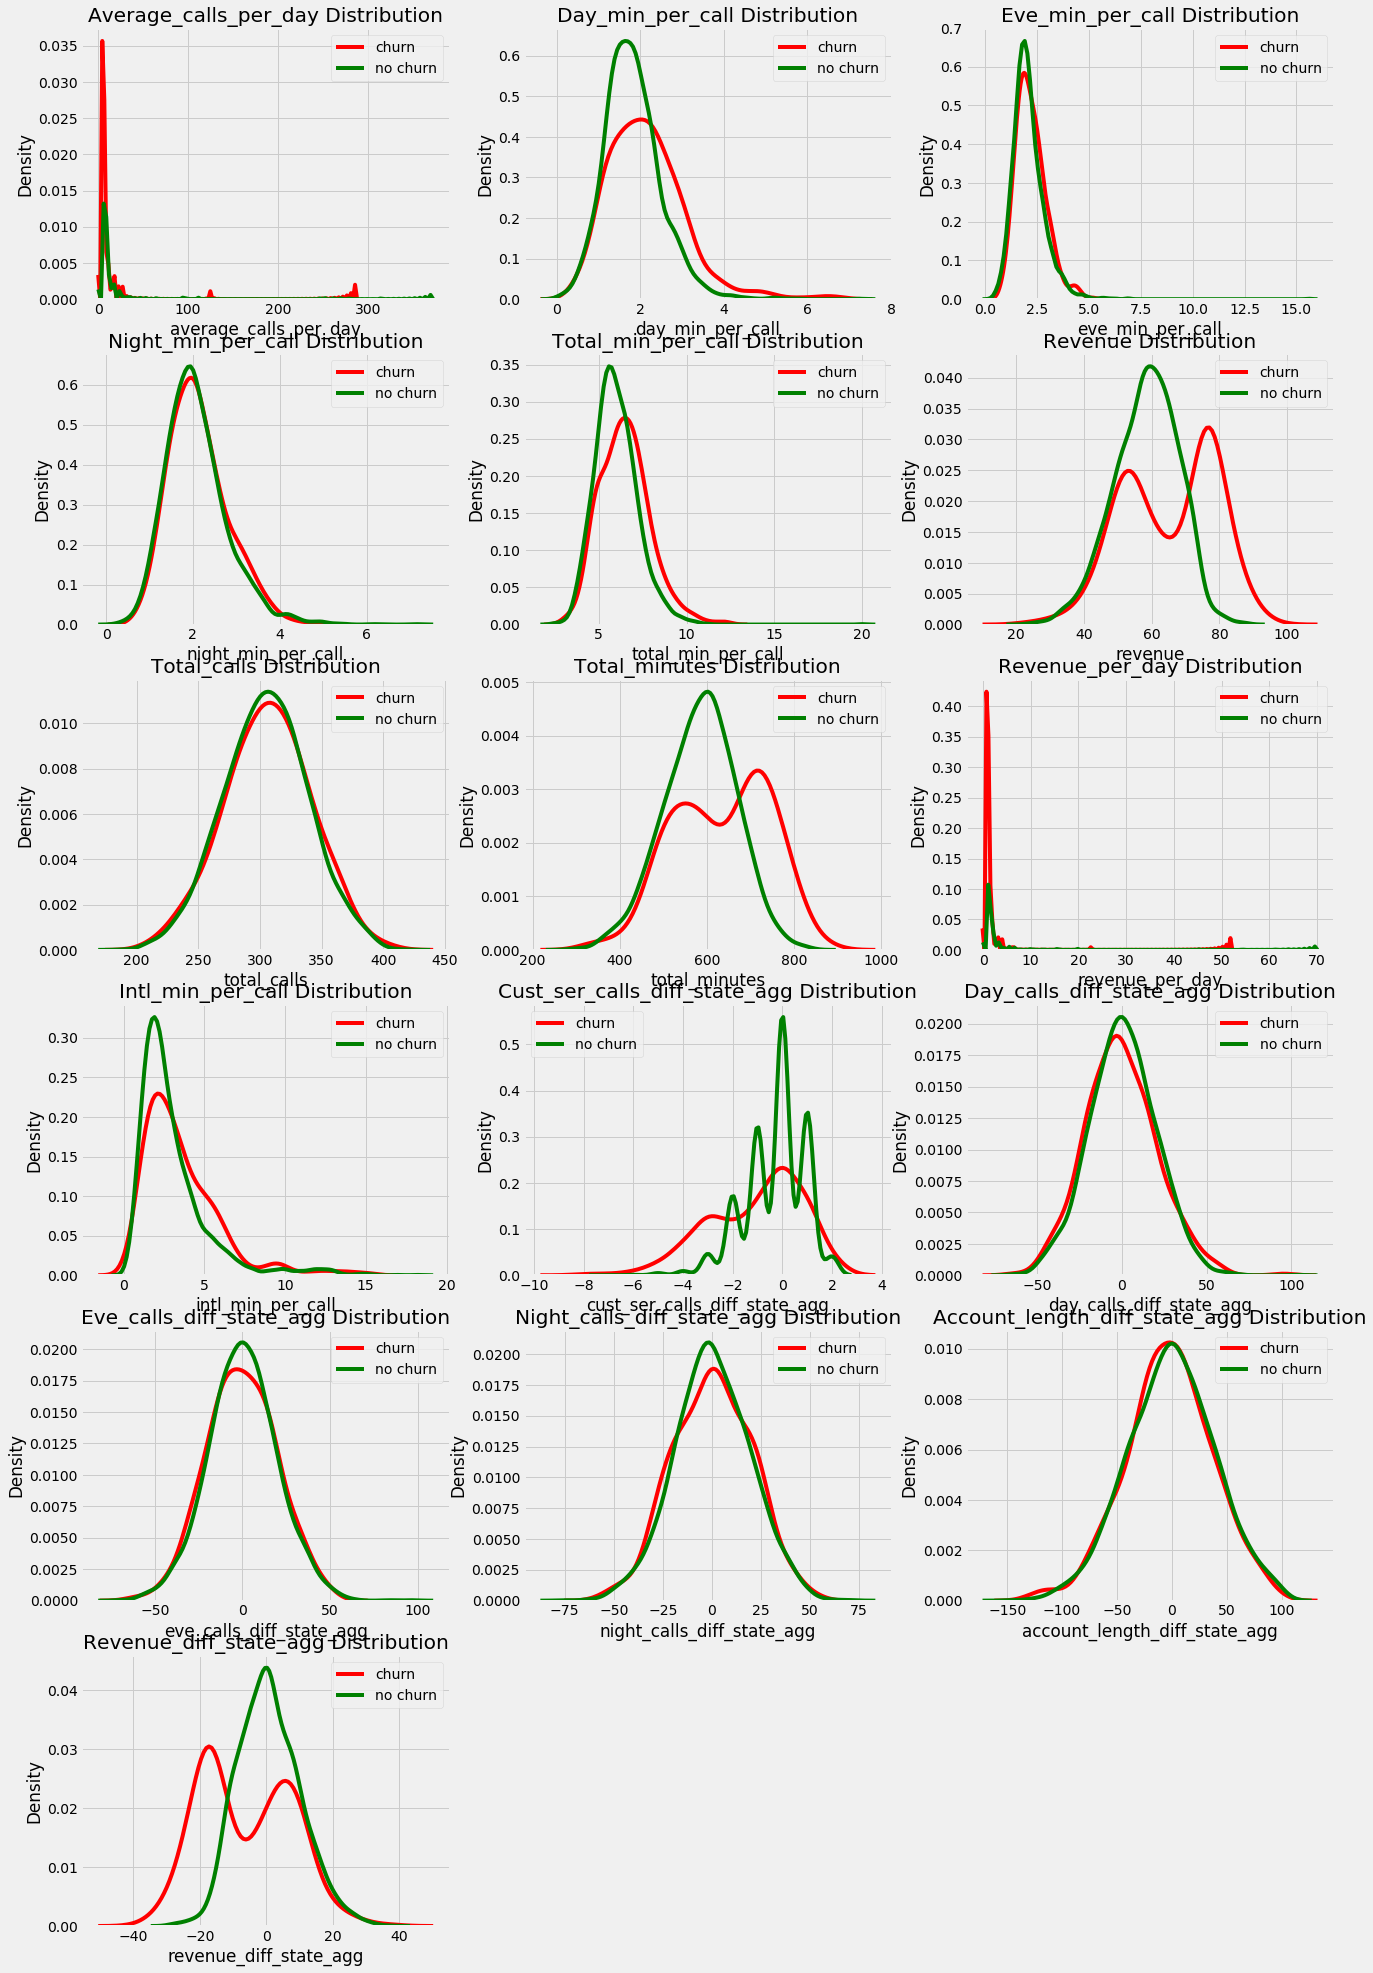

In [22]:
plot_distribution_cat(churn_data,engineered_cont_features)

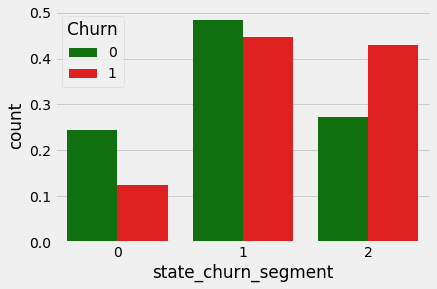

In [358]:
churn_segments_grouped = churn_data.groupby('Churn')['state_churn_segment'].value_counts(normalize=True)
churn_segments_grouped = churn_segments_grouped.rename('count')
churn_segments_grouped = churn_segments_grouped.reset_index(['Churn','state_churn_segment'])
sns.barplot(x='state_churn_segment',y='count',data=churn_segments_grouped,hue='Churn',palette=OrderedDict({1: 'red', 0: 'green'}))
plt.show()

## Correlation plot

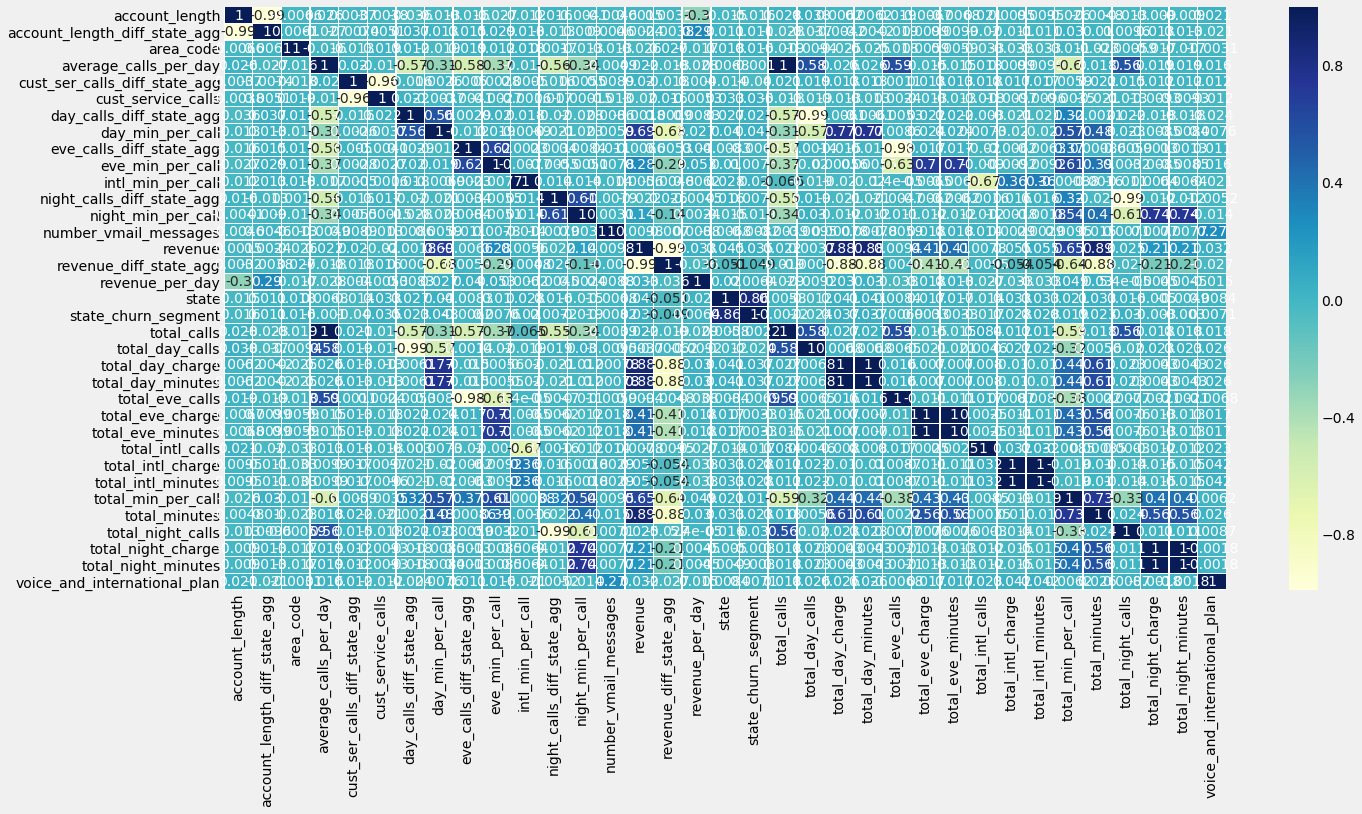

In [359]:
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(churn_data.corr(), annot=True, linewidths=.5, ax=ax,cmap="YlGnBu")
plt.show()

## Scaling the features

In [504]:
churn_data.replace([np.inf, -np.inf],np.nan,inplace=True)
churn_data.fillna(0,axis=1,inplace=True)
churn_data_test.replace([np.inf, -np.inf],np.nan,inplace=True)
churn_data_test.fillna(0,axis=1,inplace=True)

In [506]:
#scaling features to remove data collinearity
standard_scaler = StandardScaler()
churn_data_scaled_X = standard_scaler.fit_transform(churn_data[churn_data.columns.difference(['Churn'])])

C:\Users\farazz\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\farazz\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [507]:
#scaling test data
churn_data_test_scaled_X = standard_scaler.transform(churn_data_test[churn_data_test.columns.difference(['Churn'])])

C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


## Detecting Multicollinearity using Variance Inflation Factor

#### Iteration 1 

In [453]:
df = pd.DataFrame(churn_data_scaled_X,columns=list(churn_data.columns.difference(['Churn'])))

In [455]:
df['Churn'] = churn_data['Churn']

In [457]:
features = '+'.join(list(df.columns.difference(['Churn'])))

In [458]:
y, X = dmatrices('Churn ~' + features, df, return_type='dataframe')

In [459]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [460]:
vif.sort_values(by='VIF Factor',ascending=False).round(1)

,VIF Factor,features
30,inf,total_intl_minutes
28,inf,total_intl_calls
26,inf,total_eve_charge
25,inf,total_eve_calls
24,inf,total_day_minutes
23,inf,total_day_charge
22,inf,total_day_calls
21,inf,total_calls
29,inf,total_intl_charge
32,inf,total_minutes


In [461]:
drop_features_1=['average_calls_per_day','eve_min_per_call','night_min_per_call','total_calls','day_calls_diff_state_agg','account_length_diff_state_agg','total_day_charge','total_night_charge','total_eve_charge','total_intl_charge']
df.drop(drop_features_1,inplace=True,axis=1)

#### Iteration 2

In [462]:
features = '+'.join(list(df.columns.difference(['Churn'])))
y, X = dmatrices('Churn ~' + features, df, return_type='dataframe')

In [463]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [464]:
vif.sort_values(by='VIF Factor',ascending=False).round(1)

,VIF Factor,features
19,inf,total_eve_minutes
25,inf,total_night_minutes
17,inf,total_day_minutes
21,inf,total_intl_minutes
23,inf,total_minutes
11,3.410787e+06,revenue
24,5.660000e+01,total_night_calls
9,5.440000e+01,night_calls_diff_state_agg
12,4.970000e+01,revenue_diff_state_agg
18,3.390000e+01,total_eve_calls


In [465]:
drop_features_2 = ['total_minutes']
df.drop(drop_features_2,axis=1,inplace=True)

In [508]:
#removing features from training and test set
features_to_drop = drop_features_1 + drop_features_2

In [509]:
training_set = pd.DataFrame(churn_data_scaled_X,columns=churn_data.columns.difference(['Churn']))
training_labels = churn_data['Churn']

In [510]:
training_set.drop(features_to_drop,axis=1,inplace=True)

In [511]:
testing_set = pd.DataFrame(churn_data_test_scaled_X,columns=churn_data_test.columns.difference(['Churn']))
testing_labels = churn_data_test['Churn']

In [512]:
testing_set.drop(features_to_drop,axis=1,inplace=True)

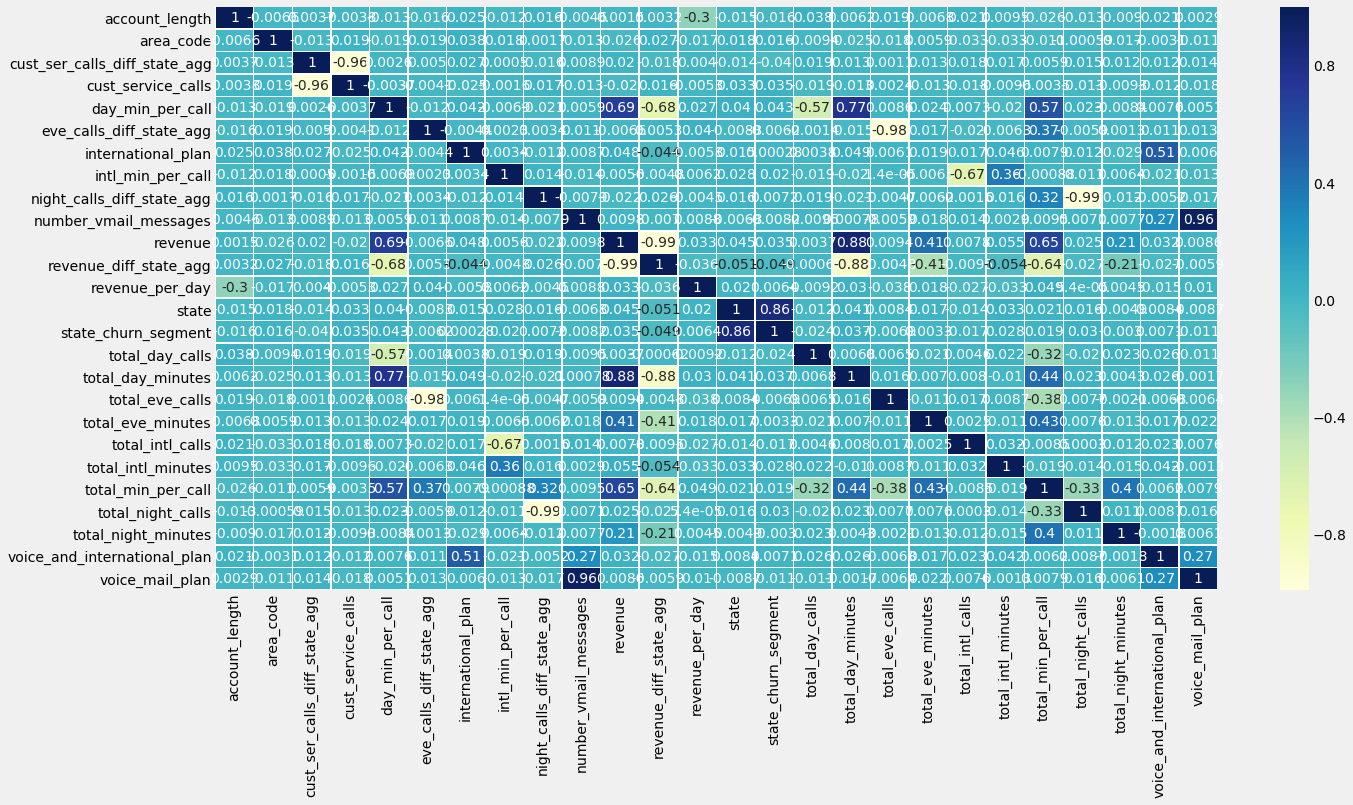

In [472]:
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(training_set.corr(), annot=True, linewidths=.5, ax=ax,cmap="YlGnBu")
plt.show()

## Data Visualization using TSNE

tsne with perplexity 5 completed in 0.7147796432177226 min
tsne with perplexity 30 completed in 0.8183481494585673 min
tsne with perplexity 50 completed in 1.2390841801961263 min
tsne with perplexity 100 completed in 1.2783883333206176 min


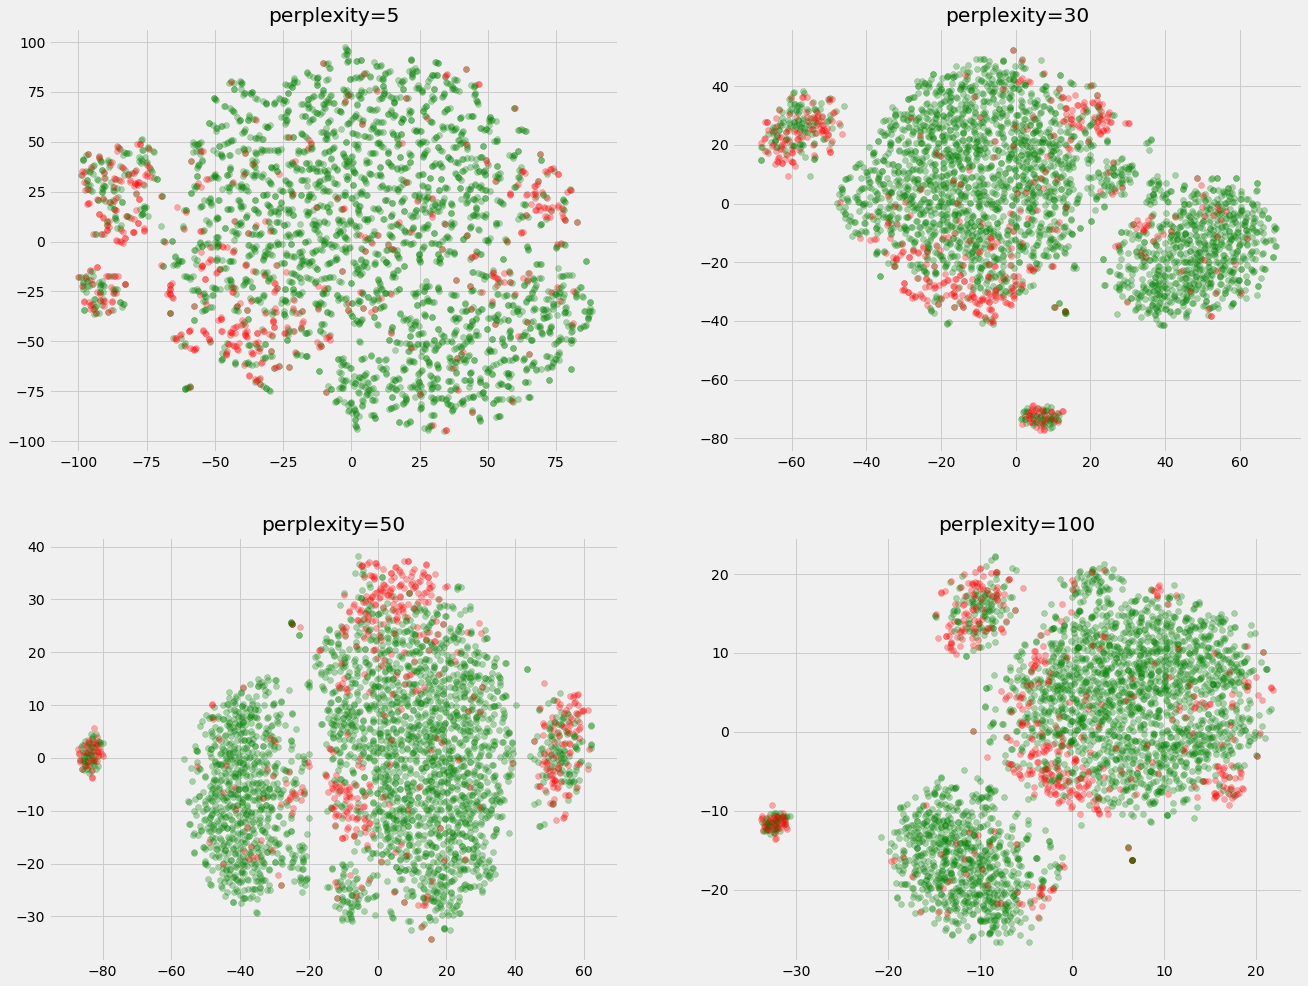

In [518]:
perplexities = [5,30,50,100]
targets = [0,1]
labels = ['no_churn','churn']
colors = ['g','r']
plt.figure(figsize = (20, 16))
for i,perplexity in enumerate(perplexities):
    ax = plt.subplot(2,2,i+1)
    t0 = time()
    tsne_embedding = TSNE(n_components=2,perplexity=perplexity)
    embedding = tsne_embedding.fit_transform(training_set)
    t1 = time()
    print('tsne with perplexity {} completed in {} min'.format(perplexity,(t1-t0)/60))
    tsne_result = pd.DataFrame({'X':embedding[:,0],'Y':embedding[:,1],'target':training_labels})
    for target,label,color in [(targets[i],labels[i],colors[i]) for i in range(0,2)]:
        ax.scatter(x=tsne_result['X'][tsne_result.target == target].values,y=tsne_result['Y'][tsne_result.target == target].values,color= color,label=\
        label,alpha=0.3)
    plt.title('perplexity={}'.format(perplexity))

## Modeling Stage

In [602]:
#for storing model results
model_results = list()

# Logistic Regression

In [796]:
#logistic regression using bayesian optimization
#parameter space
space = {'C':hp.uniform('C', 0.001, 1000),
         'penalty':hp.choice('penalty',[{'penalty':'l1','solver':'saga'},
                                        {'penalty':'l2','solver':'sag'}])}

In [797]:
#objective function
N_FOLDS = 5
def LR_objective(params,num_folds = N_FOLDS):
    
    global ITERATION
    
    ITERATION += 1
    
    penalty = params['penalty']['penalty']
    solver = params['penalty']['solver']
    reg = float(params['C'])
    
    valid_results = list()
    
    # Build the model
    log_reg = LogisticRegression(C=reg,solver=solver,penalty=penalty,n_jobs=-1)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = num_folds, shuffle = True)
    
    # Perform n_folds cross validation
    for train_indices, valid_indices in strkfold.split(training_set, training_labels):
        
        # Training and validation data
        X_train = training_set.iloc[train_indices]
        X_valid = training_set.iloc[valid_indices]
        y_train = training_labels.iloc[train_indices]
        y_valid = training_labels.iloc[valid_indices]
        
        rand_ovr = RandomOverSampler(random_state=50)
        X_train_sampled,y_train_sampled = rand_ovr.fit_sample(X_train,y_train)
    
        start = timer()

        log_reg.fit(X_train_sampled,y_train_sampled)

        runtime = timer() - start
        
        pred = log_reg.predict(X_valid)
    
        #f1_score_ = f1_score(y_valid,pred,average='binary')
        f1_score_ = log_reg.score(X_valid,y_valid)
        
        valid_results.append(f1_score_)
        
    mean_valid_results = np.mean(valid_results)
    
    std_valid_results = np.std(valid_results)
    
    loss = 1 - mean_valid_results
    
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {np.round(mean_valid_results, 4)}.')
    
    return {'loss': loss, 'params': params, 'iteration': ITERATION,'score':mean_valid_results,'score_std':std_valid_results,
            'train_time': runtime, 'status': STATUS_OK}
    

In [798]:
tpe_algorithm = tpe.suggest

In [799]:
lr_bayes_trials = Trials()

In [800]:
ITERATION = 0
PROGRESS = 10
MAX_EVALS = 100

In [801]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

# Global variable
global  ITERATION

start = timer()
best = fmin(fn = LR_objective, space = space, algo = tpe_algorithm, 
            max_evals = MAX_EVALS, trials = lr_bayes_trials, rstate = np.random.RandomState(50))
runtime = timer() - start

'Running Optimization for 100 Trials.'

'Iteration: 10, Current Score: 0.772.'

'Iteration: 20, Current Score: 0.7747.'

'Iteration: 30, Current Score: 0.7696.'

'Iteration: 40, Current Score: 0.769.'

'Iteration: 50, Current Score: 0.766.'

'Iteration: 60, Current Score: 0.7753.'

'Iteration: 70, Current Score: 0.7732.'

'Iteration: 80, Current Score: 0.769.'

'Iteration: 90, Current Score: 0.7663.'

'Iteration: 100, Current Score: 0.7684.'

In [802]:
print('total runtime for optimization: ',np.round(runtime/60,2),'min')

total runtime for optimization:  5.03 min


In [803]:
lr_results = dict_to_pd('LR',lr_bayes_trials.results)

In [804]:
lr_results.head()

,C,iteration,loss,penalty,score,score_std,solver
0,268.196867,62,0.220525,l1,0.779475,0.019177,saga
1,975.123929,3,0.222623,l1,0.777377,0.006432,saga
2,686.751668,17,0.223523,l1,0.776477,0.011235,saga
3,91.278272,7,0.223821,l2,0.776179,0.006818,sag
4,926.724238,55,0.224411,l1,0.775589,0.018376,saga


In [805]:
best_params = dict(lr_results.loc[0,['C','penalty','solver']])
best_params

{'C': 268.19686667780763, 'penalty': 'l1', 'solver': 'saga'}

In [541]:
#predicting the test set by using the best hyper-parameters found on the training set

In [806]:
rand_ovr = RandomOverSampler(random_state=50)
X_train_sampled,y_train_sampled = rand_ovr.fit_sample(training_set,training_labels)

In [807]:
log_reg = LogisticRegression(**best_params,n_jobs=-1,max_iter=1000)
log_reg.fit(X_train_sampled,y_train_sampled)

LogisticRegression(C=268.19686667780763, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [808]:
pred = log_reg.predict(testing_set)
pred_proba = log_reg.predict(testing_set)

In [809]:
feature_importances = log_reg.coef_
pd.DataFrame(feature_importances,columns=list(training_set.columns))

,account_length,area_code,cust_ser_calls_diff_state_agg,cust_service_calls,day_min_per_call,eve_calls_diff_state_agg,international_plan,intl_min_per_call,night_calls_diff_state_agg,number_vmail_messages,revenue,revenue_diff_state_agg,revenue_per_day,state,state_churn_segment,total_day_calls,total_day_minutes,total_eve_calls,total_eve_minutes,total_intl_calls,total_intl_minutes,total_min_per_call,total_night_calls,total_night_minutes,voice_and_international_plan,voice_mail_plan
0,0.017218,0.042213,-0.276,0.538127,0.331554,0.211037,0.61413,0.142289,0.021038,0.625011,0.301088,-0.355089,-0.014066,0.488422,-0.023925,0.039339,0.081337,0.03253,0.362523,-0.069415,0.06917,-0.599051,-0.18267,0.299652,0.131878,-1.048005


In [810]:
accuracy = log_reg.score(testing_set,testing_labels)
accuracy

0.7654469106178764

In [811]:
f1_score_ = f1_score(testing_labels,pred,average='binary')

In [812]:
f1_score_

0.45919778699861696

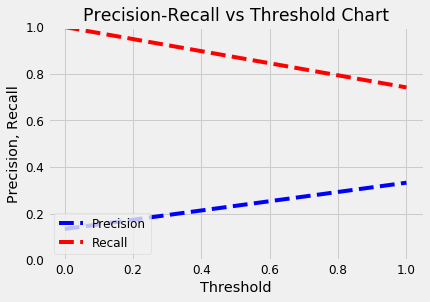

In [813]:
plot_precision_recall_curve(testing_labels,pred_proba)

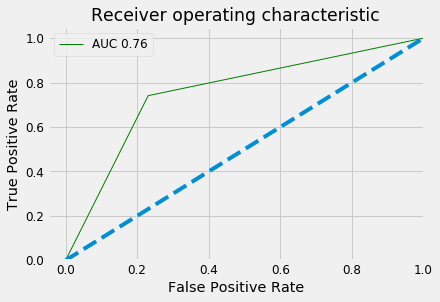

In [814]:
plot_roc_curve(testing_labels,pred_proba)
fpr,tpr,thresholds = roc_curve(testing_labels,pred_proba,pos_label=1)
auc_ = auc(fpr,tpr)

In [576]:
print(classification_report(testing_labels,pred,target_names=['no_churn','churn']))

              precision    recall  f1-score   support

    no_churn       0.95      0.77      0.85      1443
       churn       0.33      0.74      0.46       224

   micro avg       0.77      0.77      0.77      1667
   macro avg       0.64      0.76      0.65      1667
weighted avg       0.87      0.77      0.80      1667



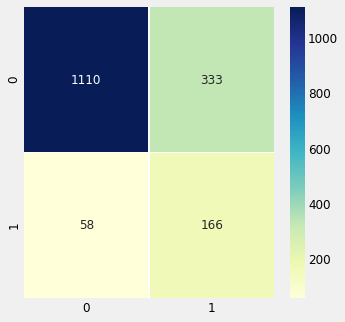

In [815]:
conf_matrix = confusion_matrix(testing_labels,pred)
fig, ax = plt.subplots(figsize=(5,5))         # Sample figsize in inches
sns.heatmap(conf_matrix, annot=True, linewidths=.5, ax=ax,cmap="YlGnBu",fmt="d")
plt.show()

In [690]:
lr_results_dict = {'model_name':'logistic_regression','accuracy':accuracy,'f1-score':f1_score_,'auc':auc_}
model_results.append(lr_results_dict)

# SVM

In [623]:
#search space
num_features = training_set.shape[1]
gamma_max = 1/(num_features * training_set.values.std())
space = {'C':hp.uniform('C',0.0001,1000),
         'gamma':hp.uniform('gamma',0,gamma_max),
         'kernel':hp.choice('kernel',['rbf','poly','sigmoid','gaussian'])}

In [700]:
NUM_FOLDS=5
def SVC_objective(params,num_folds=NUM_FOLDS):
    global ITERATION
    ITERATION += 1
    
    gamma = params['gamma']
    reg = float(params['C'])
    kernel = params['kernel']
    
    if kernel == 'gaussian':
        gaussian_kernel = partial(build_gauss_kernel,gamma=gamma)
        svc = SVC(C=reg,kernel=gaussian_kernel,decision_function_shape='ovr',probability=False)
    else :
        svc = SVC(C=reg,kernel=kernel,gamma=gamma,decision_function_shape='ovr',probability=False)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = num_folds, shuffle = True)
    
    valid_results = list()
    
    # Perform n_folds cross validation
    for train_indices, valid_indices in strkfold.split(training_set, training_labels):
        
        # Training and validation data
        X_train = training_set.iloc[train_indices]
        X_valid = training_set.iloc[valid_indices]
        y_train = training_labels.iloc[train_indices]
        y_valid = training_labels.iloc[valid_indices]
        
        rand_ovr = RandomOverSampler(random_state=50)
        X_train_sampled,y_train_sampled = rand_ovr.fit_sample(X_train,y_train)
    
        start = timer()

        svc.fit(X_train_sampled,y_train_sampled)

        runtime = timer() - start
        
        pred = svc.predict(X_valid)
    
        #f1_score_ = f1_score(y_valid,pred,average='binary')
        f1_score_ = svc.score(X_valid,y_valid)
        
        valid_results.append(f1_score_)
        
    mean_valid_results = np.mean(valid_results)
    
    std_valid_results = np.std(valid_results)
    
    loss = 1 - mean_valid_results
    
    
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {np.round(mean_valid_results, 4)}.')
    
    return {'loss': loss, 'params': params, 'iteration': ITERATION,'score':mean_valid_results,'score_std':std_valid_results,
            'train_time': runtime, 'status': STATUS_OK}
    
    

In [701]:
tpe_algorithm = tpe.suggest

In [702]:
svc_bayes_trials = Trials()

In [703]:
# Global variable
global  ITERATION

ITERATION = 0
PROGRESS = 10
MAX_EVALS = 100

In [704]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

start = timer()
best = fmin(fn = SVC_objective, space = space, algo = tpe_algorithm, 
            max_evals = MAX_EVALS, trials = svc_bayes_trials, rstate = np.random.RandomState(50))
runtime = timer() - start

'Running Optimization for 100 Trials.'

'Iteration: 10, Current Score: 0.9103.'

'Iteration: 20, Current Score: 0.8674.'

'Iteration: 30, Current Score: 0.892.'

'Iteration: 40, Current Score: 0.8551.'

'Iteration: 50, Current Score: 0.9178.'

'Iteration: 60, Current Score: 0.6097.'

'Iteration: 70, Current Score: 0.8713.'

'Iteration: 80, Current Score: 0.9136.'

'Iteration: 90, Current Score: 0.8935.'

'Iteration: 100, Current Score: 0.9025.'

In [705]:
print('total runtime for optimization: ',np.round(runtime/60,2),'min')

total runtime for optimization:  21.89 min


In [747]:
svc_results = dict_to_pd('SVC',svc_bayes_trials.results)

In [748]:
svc_results.head()

,C,iteration,kernel,loss,score,score_std
0,6.206994,78,poly,0.081007,0.918993,0.005265
1,2.123954,50,poly,0.082204,0.917796,0.009331
2,2.187939,51,poly,0.082208,0.917792,0.005645
3,1.533442,66,poly,0.083408,0.916592,0.013734
4,265.988133,82,poly,0.083705,0.916295,0.006956


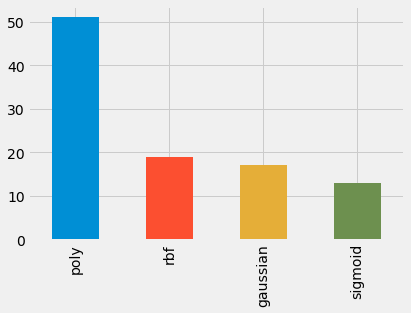

In [708]:
svc_results['kernel'].value_counts().plot.bar()
plt.show()

In [709]:
#selecting the best parameter values
best_params = dict(svc_results.loc[0,['C','kernel']])
best_params

{'C': 6.206993733218752, 'kernel': 'poly'}

In [710]:
rand_ovr = RandomOverSampler(random_state=50)
X_train_sampled,y_train_sampled = rand_ovr.fit_sample(training_set,training_labels)

In [711]:
svc = SVC(**best_params,probability=True)
svc.fit(X_train_sampled,y_train_sampled)

C:\Users\farazz\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=6.206993733218752, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [712]:
pred = svc.predict(testing_set)
pred_proba = svc.predict_proba(testing_set)

In [713]:
accuracy = svc.score(testing_set,testing_labels)
accuracy

0.883623275344931

In [714]:
f1_score_ = f1_score(testing_labels,pred,average='binary')
f1_score_

0.6135458167330677

auc-- 0.6319496353833916


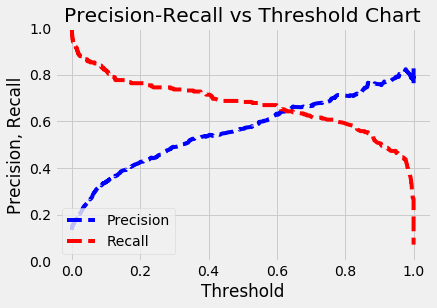

In [715]:
plot_precision_recall_curve(testing_labels,pred_proba[:,1])

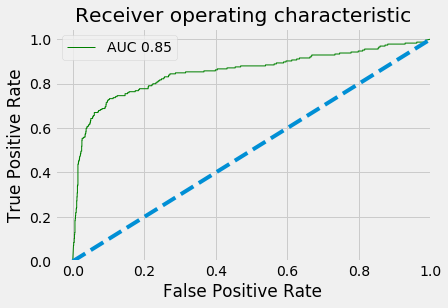

In [716]:
plot_roc_curve(testing_labels,pred_proba[:,1])
fpr,tpr,thresholds = roc_curve(testing_labels,pred_proba[:,1],pos_label=1)
auc_ = auc(fpr,tpr)

In [717]:
print(classification_report(testing_labels,pred,target_names=['no_churn','churn']))

              precision    recall  f1-score   support

    no_churn       0.95      0.91      0.93      1443
       churn       0.55      0.69      0.61       224

   micro avg       0.88      0.88      0.88      1667
   macro avg       0.75      0.80      0.77      1667
weighted avg       0.90      0.88      0.89      1667



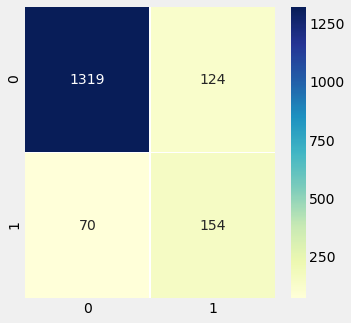

In [718]:
conf_matrix = confusion_matrix(testing_labels,pred)
fig, ax = plt.subplots(figsize=(5,5))         # Sample figsize in inches
sns.heatmap(conf_matrix, annot=True, linewidths=.5, ax=ax,cmap="YlGnBu",fmt="d")
plt.show()

In [722]:
svc_results_dict = {'model_name':'SVM','accuracy':accuracy,'f1-score':f1_score_,'auc':auc_}
model_results.append(svc_results_dict)

# GBM (Ensemble Models)

In [724]:
#domain space
space = {
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 19, 45, 1),
    'bagging_fraction':hp.uniform('feature_fraction',0.8,1),
    'min_split_gain':hp.uniform('min_split_gain',0.001,0.1),
    'min_child_weight':hp.quniform('min_child_weight',5,50,1),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 5.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 3.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'max_depth':hp.choice('max_depth',[-1,4,6,8,10,12])
}

In [738]:
N_FOLDS=5
def gbm_objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    #y_bin = label_binarize(Y_resampled, classes=[1,2,3,4])
    #n_classes = y_bin.shape[1]
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples','min_child_weight']:
        params[parameter_name] = int(params[parameter_name])
        
    strkfold = StratifiedKFold(n_splits = n_folds, shuffle = True)
    
    clf = gbm.LGBMClassifier(**params,learning_rate = 0.1,n_estimators=10000,objective='binary',importance_type='split',n_jobs=-1,metric=None)
    
    valid_scores = []
    best_estimators = []
    run_times = []
    
    # Perform n_folds cross validation
    for train_indices, valid_indices in strkfold.split(training_set, training_labels):
        
        # Training and validation data
        X_train = training_set.iloc[train_indices]
        X_valid = training_set.iloc[valid_indices]
        y_train = training_labels.iloc[train_indices]
        y_valid = training_labels.iloc[valid_indices]
        
        rand_ovr = RandomOverSampler(random_state=50)
        X_train_sampled,y_train_sampled = rand_ovr.fit_sample(X_train,y_train)
        
    
        start = timer()
        
        clf.fit(X_train_sampled, y_train_sampled, early_stopping_rounds = 400,
                  eval_metric='auc',
                  eval_set = [(X_train_sampled, y_train_sampled), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        end = timer()
        # Record the validation fold score
        valid_scores.append(clf.best_score_['valid']['auc'])
        best_estimators.append(clf.best_iteration_)
        
        run_times.append(end - start)
    
    score = np.mean(valid_scores)
    score_std = np.std(valid_scores)
    loss = 1 - score
    
    run_time = np.mean(run_times)
    run_time_std = np.std(run_times)
    
    estimators = int(np.mean(best_estimators))
    params['n_estimators'] = estimators
    
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {round(score, 4)}.')
    
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'time': run_time, 'time_std': run_time_std, 'status': STATUS_OK, 
            'score': score, 'score_std': score_std}

    

In [727]:
tpe_algorithm = tpe.suggest

In [739]:
gbm_bayes_trials = Trials()

In [740]:
ITERATION = 0
MAX_EVALS = 300
PROGRESS = 10

In [741]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

# Global variable
global  ITERATION

# Run optimization
best = fmin(fn = gbm_objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = gbm_bayes_trials, rstate = np.random.RandomState(50))

'Running Optimization for 300 Trials.'

'Iteration: 10, Current Score: 0.9337.'

'Iteration: 20, Current Score: 0.9292.'

'Iteration: 30, Current Score: 0.9352.'

'Iteration: 40, Current Score: 0.9209.'

'Iteration: 50, Current Score: 0.932.'

'Iteration: 60, Current Score: 0.9225.'

'Iteration: 70, Current Score: 0.9368.'

'Iteration: 80, Current Score: 0.9328.'

'Iteration: 90, Current Score: 0.9324.'

'Iteration: 100, Current Score: 0.9267.'

'Iteration: 110, Current Score: 0.9198.'

'Iteration: 120, Current Score: 0.9031.'

'Iteration: 130, Current Score: 0.9369.'

'Iteration: 140, Current Score: 0.9235.'

'Iteration: 150, Current Score: 0.9333.'

'Iteration: 160, Current Score: 0.926.'

'Iteration: 170, Current Score: 0.9344.'

'Iteration: 180, Current Score: 0.9272.'

'Iteration: 190, Current Score: 0.9315.'

'Iteration: 200, Current Score: 0.9276.'

'Iteration: 210, Current Score: 0.9267.'

'Iteration: 220, Current Score: 0.9269.'

'Iteration: 230, Current Score: 0.9314.'

'Iteration: 240, Current Score: 0.9244.'

'Iteration: 250, Current Score: 0.9335.'

'Iteration: 260, Current Score: 0.9317.'

'Iteration: 270, Current Score: 0.933.'

'Iteration: 280, Current Score: 0.9324.'

'Iteration: 290, Current Score: 0.9373.'

'Iteration: 300, Current Score: 0.926.'

In [745]:
gbm_results = dict_to_pd('GBM',gbm_bayes_trials.results)

In [746]:
gbm_results.head()

,bagging_fraction,boosting_type,colsample_bytree,loss,max_depth,min_child_samples,min_child_weight,min_split_gain,n_estimators,num_leaves,reg_alpha,reg_lambda,score,score_std,subsample,subsample_for_bin,train_std
0,0.827261,goss,0.783013,0.061243,12,75,7,0.093102,49,34,3.845101,2.348082,0.938757,0.021735,1.000000,240000,0.115551
1,0.818729,goss,0.716098,0.061984,12,55,10,0.042037,69,33,1.984663,2.603784,0.938016,0.016020,1.000000,280000,0.104824
2,0.953119,dart,0.862911,0.062206,-1,110,6,0.023710,161,40,0.861344,1.508384,0.937794,0.018826,0.961622,80000,2.951345
3,0.938400,dart,0.746548,0.062240,6,55,5,0.047857,72,45,2.140417,2.474207,0.937760,0.025703,0.721232,60000,0.929895
4,0.812045,dart,0.671302,0.062668,12,85,8,0.053225,100,37,1.035575,2.173472,0.937332,0.003662,0.989005,280000,1.239583


In [750]:
gbm_params = ['bagging_fraction','boosting_type','colsample_bytree','max_depth','min_child_samples','min_child_weight','min_split_gain','n_estimators','num_leaves','reg_alpha','reg_lambda','subsample','subsample_for_bin']

In [752]:
best_params = dict(gbm_results.loc[0,gbm_params])
best_params

{'bagging_fraction': 0.8272611547832797,
 'boosting_type': 'goss',
 'colsample_bytree': 0.7830128286576042,
 'max_depth': 12,
 'min_child_samples': 75,
 'min_child_weight': 7,
 'min_split_gain': 0.09310164103739309,
 'n_estimators': 49,
 'num_leaves': 34,
 'reg_alpha': 3.8451011502059473,
 'reg_lambda': 2.3480815892828435,
 'subsample': 1.0,
 'subsample_for_bin': 240000}

In [772]:
def model_gbm(features, labels, feature_list,nfolds = 5, hyp = None,with_oversampling=False):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feat_names = feature_list

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of esimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {'bagging_fraction': 0.9410068419634143,
 'boosting_type': 'dart',
 'colsample_bytree': 0.7568976937851579,
 'min_child_samples': 35,
 'min_child_weight': 26.709811008563438,
 'min_split_gain': 0.05365377666160257,
 'num_leaves': 24,
 'reg_alpha': 1.0462496845733886,
 'reg_lambda': 0.6874474257041001,
 'subsample': 0.6621345483522493,
 'subsample_for_bin': 240000}
    
    # Build the model
    model = gbm.LGBMClassifier(**params, learning_rate=0.1, objective='binary',
                             random_state=None, silent=True, 
                             n_jobs=4, n_estimators=5000)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feat_names))
    
    # Convert to arrays for indexing
    #features = np.array(features)
    #test_features = np.array(test_features)
    #labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features.iloc[train_indices]
        X_valid = features.iloc[valid_indices]
        y_train = labels.iloc[train_indices]
        y_valid = labels.iloc[valid_indices]
        
        if with_oversampling:
            rand_over = RandomOverSampler(random_state=50)
            train_set,train_labels = rand_over.fit_sample(X_train,y_train)
        else:
            train_set,train_labels = X_train,y_train
        
        
        
        
        # Train with early stopping
        model.fit(train_set, train_labels, early_stopping_rounds = 400, 
                  eval_metric = 'auc',
                  eval_set = [(train_set, train_labels), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['auc'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(testing_set)
        
         #Record each prediction for each class as a separate column
        for j in range(2):
            fold_predictions[j] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        #fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        #importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    #feature_importances = pd.DataFrame({'feature': feat_names,
                                        #'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    '''if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances'''
    
    '''# Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    # Fill in the individuals that do not have a head of household with 4 since these will not be scored
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)'''
    
    # return the submission and feature importances along with validation scores
    return feature_importances, valid_scores,predictions
    

In [773]:
feat_cols = list(training_set.columns)
gbm_fi,valid_scores,predictions = model_gbm(training_set,training_labels,feat_cols,hyp=best_params,with_oversampling=True)

Training until validation scores don't improve for 400 rounds.
[200]	train's binary_logloss: 0.0538421	train's auc: 0.999829	valid's binary_logloss: 0.103716	valid's auc: 0.966576
[400]	train's binary_logloss: 0.0449254	train's auc: 0.999916	valid's binary_logloss: 0.098413	valid's auc: 0.965455
Early stopping, best iteration is:
[69]	train's binary_logloss: 0.135942	train's auc: 0.99752	valid's binary_logloss: 0.160495	valid's auc: 0.970248


'Fold 1, Validation Score: 0.97025, Estimators Trained: 69'

Training until validation scores don't improve for 400 rounds.
[200]	train's binary_logloss: 0.0476842	train's auc: 0.999805	valid's binary_logloss: 0.150945	valid's auc: 0.910761
[400]	train's binary_logloss: 0.0445356	train's auc: 0.999851	valid's binary_logloss: 0.150696	valid's auc: 0.910074
Early stopping, best iteration is:
[1]	train's binary_logloss: 0.624338	train's auc: 0.938638	valid's binary_logloss: 0.625243	valid's auc: 0.925936


'Fold 2, Validation Score: 0.92594, Estimators Trained: 1'

Training until validation scores don't improve for 400 rounds.
[200]	train's binary_logloss: 0.0487315	train's auc: 0.999971	valid's binary_logloss: 0.140744	valid's auc: 0.91181
[400]	train's binary_logloss: 0.0429259	train's auc: 0.999981	valid's binary_logloss: 0.139541	valid's auc: 0.911557
Early stopping, best iteration is:
[1]	train's binary_logloss: 0.625097	train's auc: 0.945662	valid's binary_logloss: 0.624611	valid's auc: 0.926895


'Fold 3, Validation Score: 0.92689, Estimators Trained: 1'

Training until validation scores don't improve for 400 rounds.
[200]	train's binary_logloss: 0.0484481	train's auc: 0.999941	valid's binary_logloss: 0.135438	valid's auc: 0.916137
[400]	train's binary_logloss: 0.0439526	train's auc: 0.999974	valid's binary_logloss: 0.133087	valid's auc: 0.917416
Early stopping, best iteration is:
[24]	train's binary_logloss: 0.232524	train's auc: 0.979771	valid's binary_logloss: 0.233596	valid's auc: 0.920906


'Fold 4, Validation Score: 0.92091, Estimators Trained: 24'

Training until validation scores don't improve for 400 rounds.
[200]	train's binary_logloss: 0.0489781	train's auc: 0.999941	valid's binary_logloss: 0.145002	valid's auc: 0.910143
[400]	train's binary_logloss: 0.0423171	train's auc: 0.999946	valid's binary_logloss: 0.144564	valid's auc: 0.910417
Early stopping, best iteration is:
[1]	train's binary_logloss: 0.62452	train's auc: 0.941901	valid's binary_logloss: 0.624355	valid's auc: 0.935709


'Fold 5, Validation Score: 0.93571, Estimators Trained: 1'

'5 cross validation score: 0.93594 with std: 0.0178.'

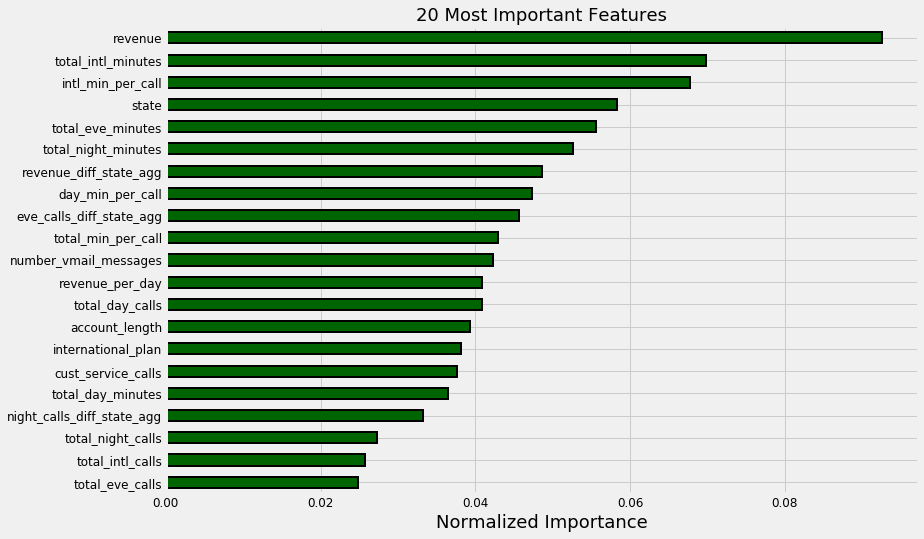

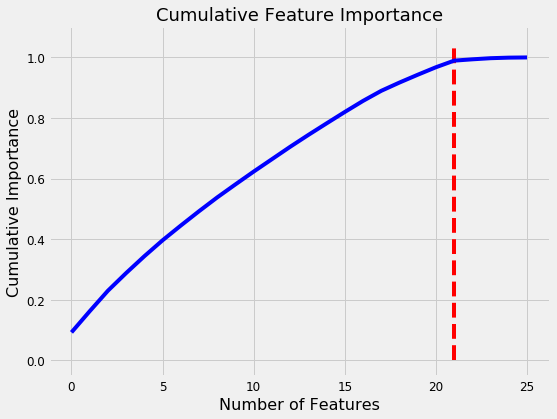

21 features required for 95% of cumulative importance.


In [765]:
feat_imp = plot_feature_importances(gbm_fi,threshold=0.95)

In [776]:
final_predictions = (predictions[predictions.fold == 1] + predictions[predictions.fold == 2] + predictions[predictions.fold == 3]+\
                    predictions[predictions.fold == 4] + predictions[predictions.fold == 5]) / 5

In [778]:
final_predictions.drop('fold',axis=1,inplace=True)

In [780]:
final_predictions['Target'] = final_predictions[[0,1]].idxmax(axis = 1)
final_predictions['confidence'] = final_predictions[[0,1]].max(axis = 1)

In [817]:
accuracy = accuracy_score(testing_labels,final_predictions['Target'])
accuracy

0.9754049190161967

In [818]:
f1_score_ = f1_score(testing_labels,final_predictions['Target'],average='binary')
f1_score_

0.9035294117647059

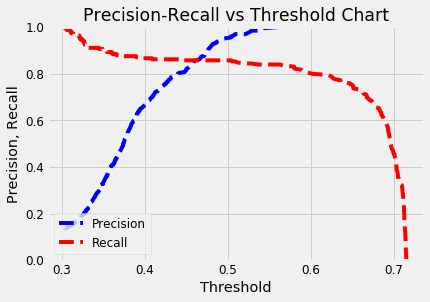

In [787]:
plot_precision_recall_curve(testing_labels,final_predictions[1])

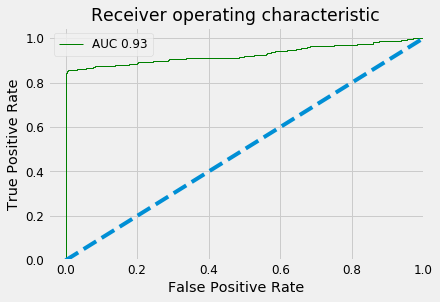

In [819]:
plot_roc_curve(testing_labels,final_predictions[1])
fpr,tpr,thresholds = roc_curve(testing_labels,final_predictions[1],pos_label=1)
auc_ = auc(fpr,tpr)

In [789]:
print(classification_report(testing_labels,final_predictions['Target'],target_names=['no_churn','churn']))

              precision    recall  f1-score   support

    no_churn       0.98      0.99      0.99      1443
       churn       0.96      0.86      0.90       224

   micro avg       0.98      0.98      0.98      1667
   macro avg       0.97      0.93      0.94      1667
weighted avg       0.98      0.98      0.97      1667



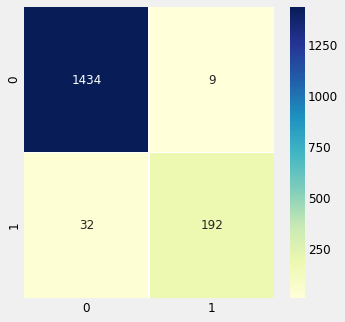

In [790]:
conf_matrix = confusion_matrix(testing_labels,final_predictions['Target'])
fig, ax = plt.subplots(figsize=(5,5))         # Sample figsize in inches
sns.heatmap(conf_matrix, annot=True, linewidths=.5, ax=ax,cmap="YlGnBu",fmt="d")
plt.show()

In [820]:
gbm_results_dict = {'model_name':'GBM','accuracy':accuracy,'f1-score':f1_score_,'auc':auc_}
model_results.append(gbm_results_dict)

In [822]:
model_results_df = pd.DataFrame(model_results)

In [825]:
model_results_df = model_results_df.set_index('model_name')

In [829]:
def plot_metrics(model_results,metric):
    model_results[metric].plot.bar(color = 'orange', figsize = (10, 6),
                                      edgecolor = 'k', linewidth = 2)
    plt.title('Model F1 Score Results')
    plt.ylabel('Mean F1 Score (with error bar)')
    plt.show()

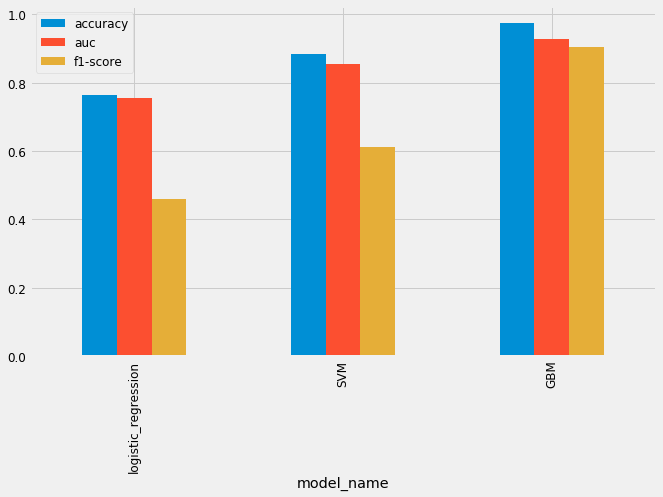

In [832]:
model_results_df.plot.bar(figsize = (10, 6))
plt.show()